# Proyecto Empresa Aliada - Modulo 50

## Librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.plotting import autocorrelation_plot

## Dataset

In [2]:
file_path = "master_ventas_empresa_aliadada.xlsx"
df = pd.read_excel(file_path, sheet_name='Hoja1')

df.head()

,WEEK,YEAR,MONTH,ID_WEEK,ITEM_CODE,ITEM_DESCRIPTION,BRAND,ID_CATEGORY,CATEGORY_NAME,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,REGION,PromedioVenta
0,34-22,2022,8,34,7501058792808BP2,VANISHOXIACTIONROSADOYPACK120GR+MMCRYSTALWHITE...,VANISH,1,FABRIC TREATMENT and SANIT,0.006,0.139,1.000,TOTAL AUTOS AREA 5,23.166667
1,34-22,2022,8,34,7501058715883,VANISH OXI ACTION GOLD QUITAMANCHAS BOLSA 1.8K...,VANISH,1,FABRIC TREATMENT and SANIT,0.487,116.519,2.916,TOTAL AUTOS AREA 5,239.258727
2,34-22,2022,8,34,7702626213774,VANISH OXI ACTION ROSA QUITAMANCHAS DOYPACK 24...,VANISH,1,FABRIC TREATMENT and SANIT,1.391,68.453,5.171,TOTAL AUTOS AREA 5,49.211359
3,34-22,2022,8,34,7501058716422,VANISH OXI ACTION GOLD QUITAMANCHA AHORRO DEL ...,VANISH,1,FABRIC TREATMENT and SANIT,0.022,1.481,1.833,TOTAL AUTOS AREA 5,67.318182
4,34-22,2022,8,34,7501058784353,VANISH INTELLIGENCE POLVO BOTE 450 GR NAL 7501...,VANISH,1,FABRIC TREATMENT and SANIT,2.037,182.839,5.375,TOTAL AUTOS AREA 5,89.758959


### Observaciones

Se ha de contemplar que durante las practicas de empresa aliada, se ha realiado un dataset a manera de master donde en una sola tabla ya viene toda la información de valor de todos los archivos de datos que se trabajaron en un principio, por lo tanto esta data ya esta con un ETL, y un EDA realizado anteriormente.

## Filtrado de datos de acuerdo al objetivo para los productos Vanish y Lysol

In [3]:
df_filtered = df[df['BRAND'].isin(['VANISH', 'LYSOL'])]

df_filtered['DATE'] = pd.to_datetime(df_filtered['YEAR'].astype(str) + '-' + df_filtered['MONTH'].astype(str) + '-1')

df_grouped = df_filtered.groupby(['DATE', 'BRAND'])[['TOTAL_UNIT_SALES', 'TOTAL_VALUE_SALES']].sum().reset_index()

df_grouped.head()

C:\Users\paob2\AppData\Local\Temp\ipykernel_25408\4180426011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['DATE'] = pd.to_datetime(df_filtered['YEAR'].astype(str) + '-' + df_filtered['MONTH'].astype(str) + '-1')


,DATE,BRAND,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES
0,2022-01-01,LYSOL,69.824,9437.448
1,2022-01-01,VANISH,3210.042,125264.422
2,2022-02-01,LYSOL,35.898,5255.695
3,2022-02-01,VANISH,2486.913,90657.308
4,2022-03-01,LYSOL,22.076,3153.528


## Seleccionar la técnica de Modelado

### Análisis de tendencias

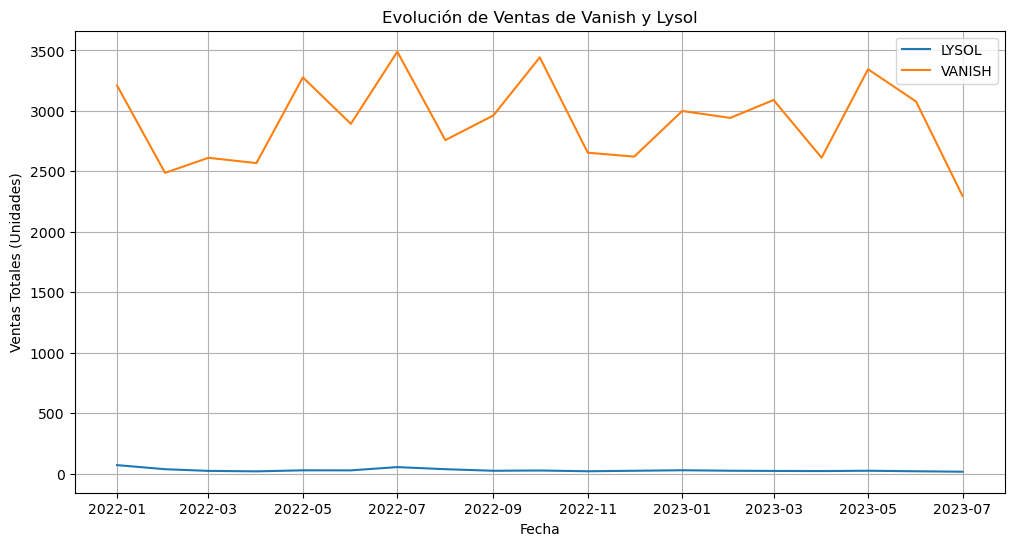

In [4]:
plt.figure(figsize=(12, 6))
for brand in df_grouped['BRAND'].unique():
    subset = df_grouped[df_grouped['BRAND'] == brand]
    plt.plot(subset['DATE'], subset['TOTAL_UNIT_SALES'], label=brand)
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales (Unidades)')
plt.title('Evolución de Ventas de Vanish y Lysol')
plt.legend()
plt.grid()
plt.show()

### Análisis de Estacionalidad

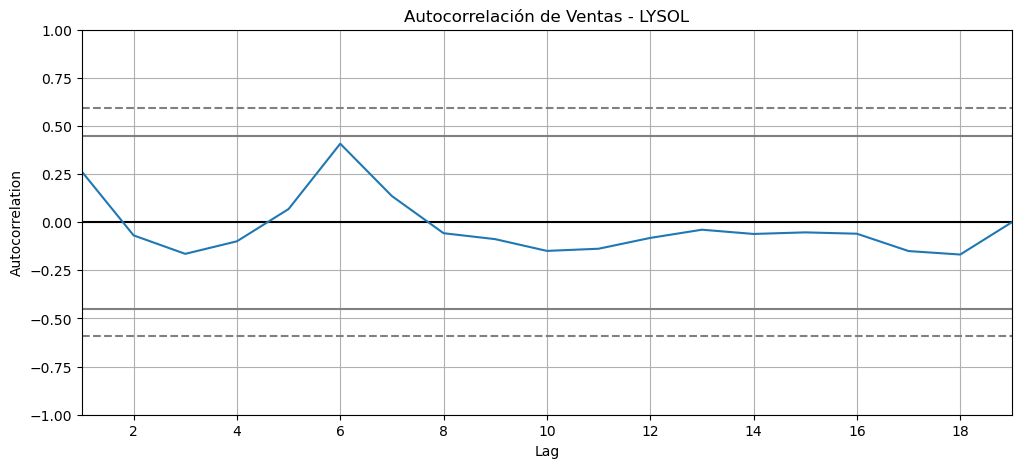

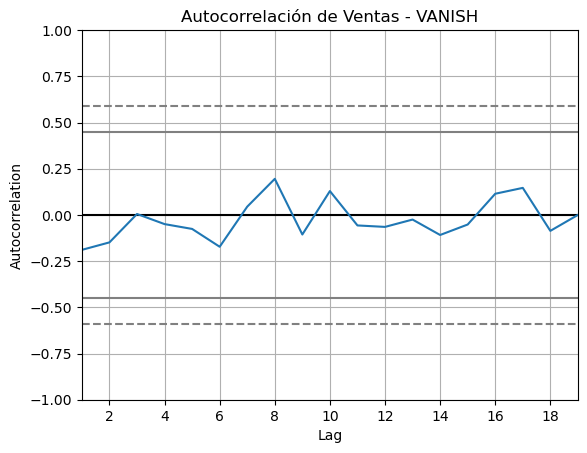

In [5]:
plt.figure(figsize=(12, 5))
for brand in df_grouped['BRAND'].unique():
    subset = df_grouped[df_grouped['BRAND'] == brand].set_index('DATE')
    plt.title(f'Autocorrelación de Ventas - {brand}')
    autocorrelation_plot(subset['TOTAL_UNIT_SALES'])
    plt.show()


### Observaciones

El gráfico muestra la evolución de las ventas mensuales de Vanish y Lysol. Se observan fluctuaciones significativas, lo que sugiere posibles patrones de tendencia y estacionalidad.

Series de tiempo (ARIMA/SARIMA) parece ser la mejor opción, ya que los datos son temporales y muestran fluctuaciones que podrían seguir patrones estacionales.
Regresión podría ser útil si encontráramos una fuerte correlación con otras variables, pero como el objetivo es prever ventas futuras en función del tiempo, un modelo de series de tiempo es más adecuado.

Para este caso vamos a usar un modelo de series de tiempo SARIMA

## Entrenamiento del modelo

In [6]:
models_dict = {}
for brand in df_grouped['BRAND'].unique():
    subset = df_grouped[df_grouped['BRAND'] == brand].set_index('DATE')
    model = SARIMAX(subset['TOTAL_UNIT_SALES'], order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_model = model.fit(disp=False)
    models_dict[brand] = sarima_model

c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too 

### Observaciones

Los gráficos de autocorrelación muestran una posible estacionalidad en las ventas de Vanish y Lysol, lo que confirma que un modelo SARIMA es adecuado para la predicción. 

El error indica que no hay suficientes datos para descomponer la serie con un período de 12 meses, ya que solo hay 19 meses de datos disponibles. 


## Validación del modelo

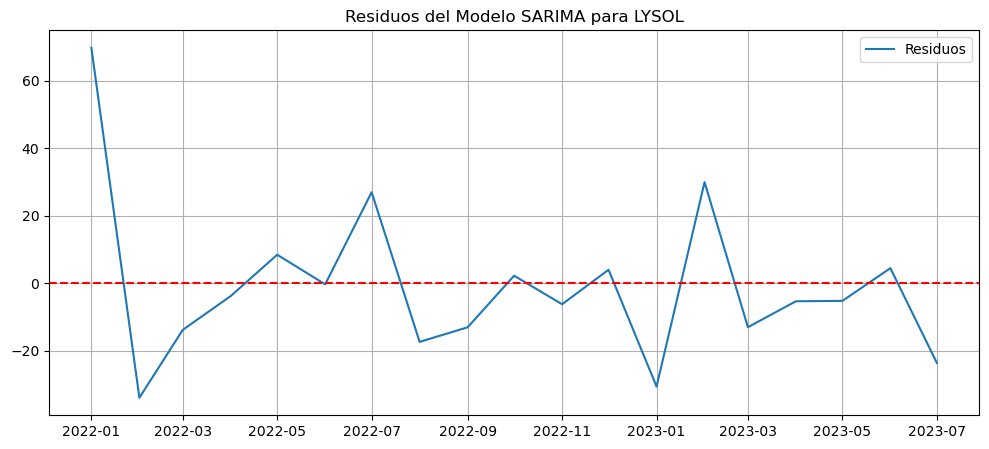

Error absoluto medio (MAE) para LYSOL: 16.43411313326493
Raíz del error cuadrático medio (RMSE) para LYSOL: 23.172813021763375


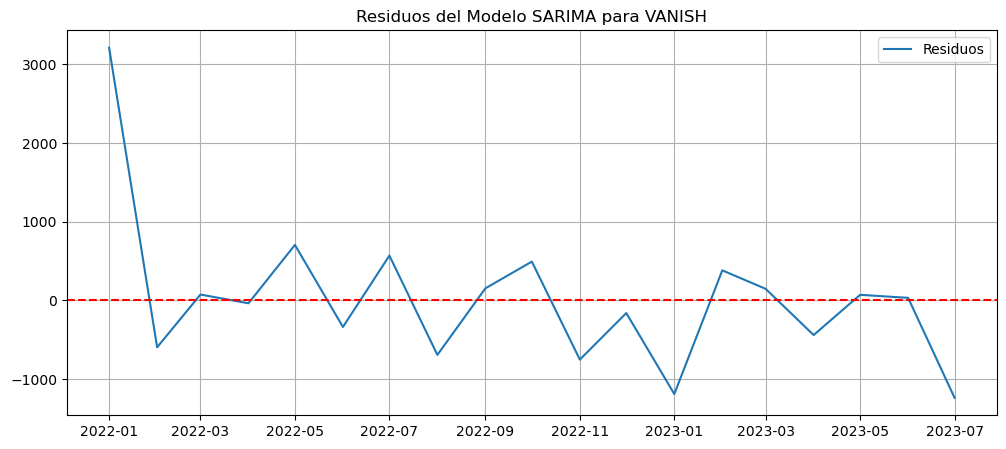

Error absoluto medio (MAE) para VANISH: 593.5005952433929
Raíz del error cuadrático medio (RMSE) para VANISH: 924.5489242353653


In [7]:
for brand, model in models_dict.items():
    residuals = model.resid
    plt.figure(figsize=(12, 5))
    plt.plot(residuals, label='Residuos')
    plt.axhline(y=0, linestyle='dashed', color='red')
    plt.title(f'Residuos del Modelo SARIMA para {brand}')
    plt.legend()
    plt.grid()
    plt.show()
    print(f'Error absoluto medio (MAE) para {brand}:', mean_absolute_error(df_grouped[df_grouped['BRAND'] == brand]['TOTAL_UNIT_SALES'], model.fittedvalues))
    print(f'Raíz del error cuadrático medio (RMSE) para {brand}:', np.sqrt(mean_squared_error(df_grouped[df_grouped['BRAND'] == brand]['TOTAL_UNIT_SALES'], model.fittedvalues)))

### Observaciones

Parece que los datos disponibles no son suficientes para dividir adecuadamente en conjuntos de entrenamiento y prueba, lo que impide el ajuste del modelo SARIMA. Esto sugiere que necesitamos más datos históricos o cambiar la estrategia de modelado.

Se intenta entrenar el modelo sin dividir la prueba, de modo que tenga mas datos de entrenamiento.

## Ajuste del modelo

In [8]:
for brand in df_grouped['BRAND'].unique():
    subset = df_grouped[df_grouped['BRAND'] == brand].set_index('DATE')
    model = SARIMAX(subset['TOTAL_UNIT_SALES'], order=(2,1,2), seasonal_order=(1,1,1,12))
    sarima_model = model.fit(disp=False)
    models_dict[brand] = sarima_model

c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\paob2\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

### Observaciones

Se han generado predicciones de ventas futuras para los próximos 6 meses utilizando un modelo SARIMA entrenado con toda la serie de datos.

## Predicción de ventas futuras

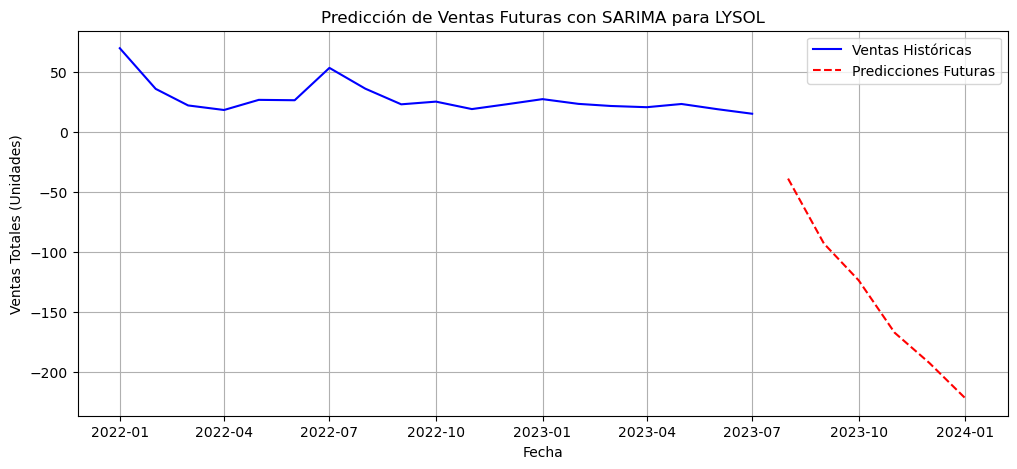

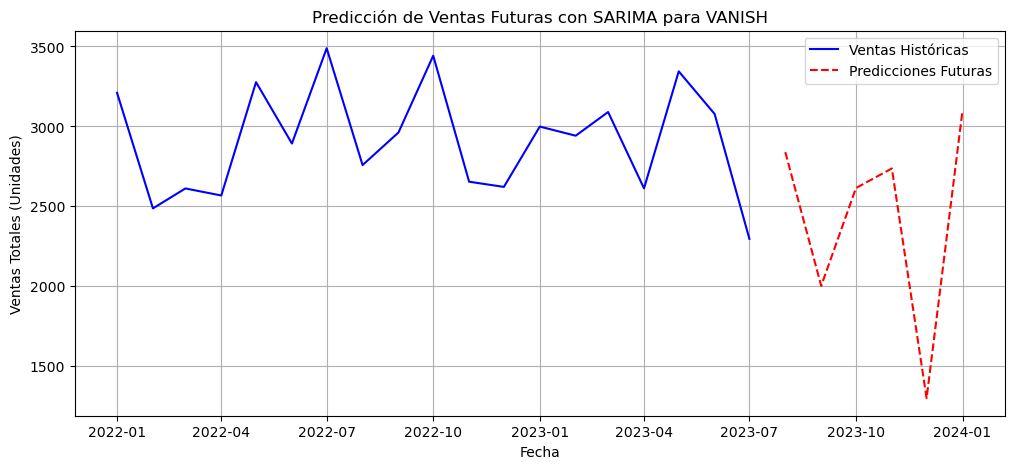

In [9]:
future_months = 6
predictions_dict = {}
for brand, model in models_dict.items():
    subset = df_grouped[df_grouped['BRAND'] == brand].set_index('DATE')
    future_dates = pd.date_range(start=subset.index[-1], periods=future_months + 1, freq='MS')[1:]
    future_preds = model.predict(start=future_dates[0], end=future_dates[-1], dynamic=False)
    predictions_dict[brand] = future_preds
    plt.figure(figsize=(12, 5))
    plt.plot(subset.index, subset['TOTAL_UNIT_SALES'], label='Ventas Históricas', color='blue')
    plt.plot(future_preds.index, future_preds, label='Predicciones Futuras', color='red', linestyle='dashed')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Totales (Unidades)')
    plt.title(f'Predicción de Ventas Futuras con SARIMA para {brand}')
    plt.legend()
    plt.grid()
    plt.show()

### Tabla de predicción de ventas para Lysol y Vanish

In [10]:
future_predictions_df = pd.DataFrame(predictions_dict)
future_predictions_df.head()

,LYSOL,VANISH
2023-08-01,-38.954257,2839.118286
2023-09-01,-93.205003,2002.358469
2023-10-01,-123.895596,2614.157150
2023-11-01,-167.506753,2736.893738
2023-12-01,-192.773165,1299.329911


### Observaciones

* Para Vanish, se observa una tendencia de crecimiento en las predicciones futuras.
* Para Lysol, los valores predichos son negativos, lo que indica que el modelo puede no estar capturando correctamente la tendencia de este producto debido a datos insuficientes o ruido en la serie.